# 1. Import Libraries

In [2]:
import gym
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import random
from collections import deque
import os
import imageio
import seaborn as sns

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# 2. Exploratory Data Analysis

## Background Information of The Environment

In [4]:
env = gym.make('Pendulum-v0')

### Description
The inverted pendulum swingup problem is based on the classic problem in control theory. 

The system consists of a pendulum attached at one end to a fixed point, and the other end being free.

The pendulum starts in a random position and the goal is to apply torque on the free end to swing it into an upright position, with its center of gravity right above the fixed point.

### Actions
The agent can apply a torque of $[-2.0, 2.0]$ to the pendulum. Torque is measured in $Nm$.

The direction of a positive torque acts in the counter-clockwise direction while the direction of a negative torque acts in the clockwise direction.

This is a set of continuous action space (infinite possible values of torque within fixed range that can be applied on the pendulum).

In [5]:
print(f'Number of Actions: {env.action_space.shape}')
print(f'Actions Space Upper Bound: {env.action_space.high}')
print(f'Actions Space Lower Bound: {env.action_space.low}')

Number of Actions: (1,)
Actions Space Upper Bound: [2.]
Actions Space Lower Bound: [-2.]


### Observations
There are 3 continuous observations in the environment (infinite possible values of the pendulum's free-end position and angular velocity):

1. x: The x-coordinate of the pendulum's free-end, measured in $m$. Derived by $x = \cos(\theta)$ with a range of $[-1.0, 1.0]$.
2. y: The y-coordinate of the pendulum's free-end, measured in $m$. Derived by $y = \sin(\angle)$ with a range of $[-1.0, 1.0]$.
3. Angular Velocity: The angular velocity of the pendulum's free-end. The range is $[-8.0, 8.0]$.

In [6]:
print(f'Number of Observation Space: {env.observation_space.shape}')
print(f'Observation Space Upper Bound: {env.observation_space.high}')
print(f'Observation Space Lower Bound: {env.observation_space.low}')

Number of Observation Space: (3,)
Observation Space Upper Bound: [1. 1. 8.]
Observation Space Lower Bound: [-1. -1. -8.]


### Rewards
After a torque is applied to the pendulum, the agent receives a reward for that action. The reward is calculated as follows:

$r = -(\theta^2 + 0.1 * \theta \_dt^2 + 0.001 * torque^2)$, where $\theta$ is the angle of the pendulum normalized between $[-\pi, \pi]$ (with 0 being in the upright position), $\theta \_dt$ is the angular velocity of the pendulum, and $torque$ is the torque applied to the pendulum.

The minimum reward that can be obtained is $-(\pi^2 + 0.1 * 82 + 0.001 * 22) = -16.2736044$, while the maximum reward is zero (pendulum is upright with zero velocity and no torque applied).

Hence $r$ is between $[-16.2736044, 0]$

NOTE: Reward $\ne$ Return. Return is the sum of rewards obtained from the start of the episode to an end of an episode.

### Starting State

The pendulum starts in a random angle in $[-\pi, \pi]$ with a random angular velocity in $[-1, 1]$.

### Episode Truncation

The episode is truncated after 200 steps.

# 3. Model Training

In [7]:
class DQN:
    def __init__(
        self,
        InputShape,
        NActions,
        Gamma,
        ReplayMemorySize,
        MinReplayMemory,
        UpdateTargetEveryThisEpisodes,
        IntermediateSize,
        BatchSize,
        LearningRate,
        Momentum
    ):
        # Hyperparameters
        self.InputShape = InputShape
        self.NActions = NActions
        self.Gamma = Gamma
        self.ReplayMemorySize = ReplayMemorySize
        self.MinReplayMemory = MinReplayMemory
        self.UpdateTargetEveryThisEpisodes = UpdateTargetEveryThisEpisodes
        self.IntermediateSize = IntermediateSize
        self.BatchSize = BatchSize
        self.LearningRate = LearningRate
        self.Momentum = Momentum
        
        # Main model
        self.Main = self.CreateModel('Main')
        self.Optimiser = Adam(learning_rate=self.LearningRate, beta_1=self.Momentum)
        
        # Target model.
        self.Target = self.CreateModel('Target')
        self.Target.set_weights(self.Main.get_weights())
        
        # Replay memory.
        self.ReplayMemory = deque(maxlen = ReplayMemorySize)
        
        # Target network update counter.
        self.TargetUpdateCounter = 0
    
    def CreateModel(self, Type):
        inputs = Input(shape = (self.InputShape,), name = 'Input')
        x = Dense(self.IntermediateSize, activation = 'relu', name = '1stHiddenLayer')(inputs)
        x = Dense(self.IntermediateSize, activation = 'relu', name = '2ndHiddenLayer')(x)
        outputs = Dense(self.NActions, activation = 'linear', name = 'Output')(x)
        
        NN = Model(inputs, outputs, name = f'{Type}')
        NN.summary()
        
        return NN
    
    def UpdateReplayMemory(self, Information): # Information = (S, A, R, SNext, Done)
        self.ReplayMemory.append(Information)

    def Train(self, EndOfEpisode):
        # Only train if replay memory has enough data. 
        if len(self.ReplayMemory) < self.MinReplayMemory:
            print(f'DID NOT TRAIN..., replay memory = {len(self.ReplayMemory)}')
            return
        
        # Get batch of data for training.        
        TrainingData = random.sample(self.ReplayMemory, self.BatchSize)
        
        # Get states from training data, then get corresponding Q values.
        ListOfS = np.array([element[0] for element in TrainingData])
        ListOfQ = np.array(self.Main(ListOfS))
        
        # Get future states from training data, then get corresponding Q values.
        ListOfSNext = np.array([element[3] for element in TrainingData])
        ListOfQNext = self.Target(ListOfSNext)
        
        # Build actual training data for neural network.
        X = []
        Y = []

        for index, (S, A, R, SNext, Done) in enumerate(TrainingData):
            if not Done:
                MaxQNext = np.max(ListOfQNext[index])
                QNext = R + self.Gamma * MaxQNext
            else:
                QNext = R
            Q = ListOfQ[index]
            Q[A] = QNext
        
            X.append(S)
            Y.append(Q)
        
        # Train model using tf.GradientTape(), defined below.
        self.GTfit(X, Y)
                
        # Update target network every episode.
        if EndOfEpisode:
            self.TargetUpdateCounter += 1
        
        # Update target if counter is full.
        if self.TargetUpdateCounter >= self.UpdateTargetEveryThisEpisodes:
            self.Target.set_weights(self.Main.get_weights())
            self.TargetUpdateCounter = 0
    
    # This is the tf.GradientTape() which significantly speeds up training of neural networks.
    @tf.function
    def GTfit(self, X, Y):
        # Train the neural network with this batch of data.
        with tf.GradientTape() as tape:
            Predictions = self.Main(tf.convert_to_tensor(X), training = True)
            Loss = tf.math.reduce_mean(tf.math.square(tf.convert_to_tensor(Y) - Predictions))
        Grad = tape.gradient(Loss, self.Main.trainable_variables)
        self.Optimiser.apply_gradients(zip(Grad, self.Main.trainable_variables))

    def SaveWeights(self, ModelName):
        if not os.path.exists('weights'):
            os.makedirs('weights')

        self.Main.save_weights(f'weights/{ModelName}_main.weights.h5')
        self.Target.save_weights(f'weights/{ModelName}_target.weights.h5')
        
    def LoadWeights(self, ModelName):
        self.Main.load_weights(f'weights/{ModelName}_main.weights.h5')
        self.Target.load_weights(f'weights/{ModelName}_target.weights.h5')

In [8]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

def PendulumActionConverter(A, NActions):
    ActualTorque = (A / NActions - 0.5) * 4
    return ActualTorque

def PendulumInverseActionConverter(A, NActions):
    ActualA = round((A + 2) * (NActions - 1) / 4)
    return ActualA

def OneEpisode(DQN):
    env = gym.make(f'{EnvName}')
    S = env.reset()
    ListOfRewards = []
    Done = False
    
    while not Done:
        Q = DQN.Main(S.reshape(-1, S.shape[0]))
        if np.random.rand() < Epsilon:
            AStep = env.action_space.sample()
            A = PendulumInverseActionConverter(AStep[0], NActions)
        else:
            A = np.argmax(Q)
            A = PendulumActionConverter(A, NActions)
            AStep = np.array([A])
            A = PendulumInverseActionConverter(A, NActions)
        if not episode % ShowEvery and len(DQN.ReplayMemory) >= DQN.MinReplayMemory:
            frame = env.render(mode='rgb_array')
            frames.append(frame)
        SNext, R, Done, Info = env.step(AStep)
        DQN.UpdateReplayMemory((S, A, R, SNext, Done))
        DQN.Train(Done)
        ListOfRewards.append(R)
        if Done:
            print(f'Finished! Return: {np.sum(ListOfRewards)}')
            returns.append(np.sum(ListOfRewards))
            env.close()
            return
        S = SNext

def ReturnPlot(path, title, window_size=10):
    plt.figure(figsize=(10, 5))

    plt.plot(returns, label="Returns")
    
    # Calculate and plot the moving average
    if len(returns) >= window_size:
        moving_avg = moving_average(returns, window_size)
        plt.plot(range(window_size - 1, len(returns)), moving_avg, label=f"Moving Average (window size = {window_size})", color='red')
    
    plt.xlabel("Episodes")
    plt.ylabel("Returns")
    plt.title(title)
    plt.legend()

    if not os.path.exists("plots"):
        os.makedirs("plots")
    
    plt.savefig(f"plots/{path}.png")
    plt.show()

def SaveVideo(path, fps=30):
    if not os.path.exists("videos"):
        os.makedirs("videos")
    writer = imageio.get_writer(f'videos/{path}.mp4', fps=fps)
    for frame in frames:
        writer.append_data(frame)
    writer.close()

In [9]:
EnvName = 'Pendulum-v0'
ShowEvery = 10
InputShape = 3

## A. Baseline Model (Untuned Hyperparameters)

Model: "Main"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 40)             │         2,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,016 (27.41 KB)

 Trainable params: 7,016 (27.41 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Target"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 40)             │         2,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,016 (27.41 KB)

 Trainable params: 7,016 (27.41 KB)

 Non-trainable params: 0 (0.00 B)

Episode 0
DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory = 26
DID NOT TRAIN..., replay memory = 27


C:\Users\scrab\AppData\Local\Temp\ipykernel_2188\3798741468.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


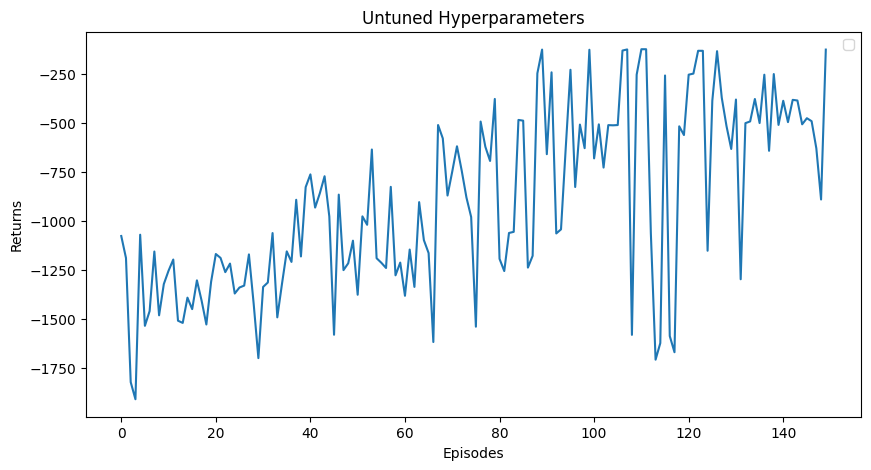

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [9]:
# Hyperparameters
IntermediateSize = 64
Epsilon = 0.1
NActions = 40
Gamma = 1
ReplayMemorySize = 10000
MinReplayMemory = 1000
UpdateTargetEveryThisEpisodes = 1
BatchSize = 32
LearningRate = 0.001
Momentum = 0.9

returns = []
frames = []
STARTTIME = time.time()

baselineDQN = DQN(
    IntermediateSize=IntermediateSize,
    InputShape=InputShape,
    NActions=NActions,
    Gamma=Gamma,
    ReplayMemorySize=ReplayMemorySize,
    MinReplayMemory=MinReplayMemory,
    UpdateTargetEveryThisEpisodes=UpdateTargetEveryThisEpisodes,
    BatchSize=BatchSize,
    LearningRate=LearningRate,
    Momentum=Momentum
)

for episode in range(150):
    print(f'Episode {episode}')
    OneEpisode(baselineDQN)

print(f'Total time taken: {time.time() - STARTTIME} seconds ...')

ReturnPlot('baselineDQN', 'Untuned Hyperparameters')
SaveVideo('baselineDQN')


## B. Improved Model (Tuned Hyperparameters)

### How do we determine which hyperparameters are good? Stability vs Performance

We have decided to focus abit more on stability than performance as a more consistent performing model is, in our opinion, more valuable than a model that performs well very inconsistently.

Hence, for each time we change the hyperparameters, we will run it 2 times and see whether the graphs are consistent with each other to ensure that the model is stable.

### Epsilon & Gamma

We will be focusing on the epsilon and gamma hyperparameters for the first improved model.

Epsilon is the exploration rate of the agent. It determines the probability of the agent taking a random action instead of the action that will maximize the reward.

Gamma is the discount factor of the agent. It determines the importance of future rewards. A value of 0 makes the agent short-sighted by only considering current rewards, while a value of 1 makes the agent long-sighted by considering future rewards.

However, we do not want to use a gamma value of 1 as it will make the agent consider an infinite future leading to an infinite sum of rewards. This means the agent will never converge to an optimal policy, as it will always be optimizing for future rewards. Hence, we will use gamma < 1.

Our goal is to be far-sighted, but not too far-sighted that the agent becomes too greedy and fails to take into consideration the future impact of the current action.

We also want the model to explore more at the start to learn the environment better and discovering more actions rather than sticking to a single action that it perceives as good. However, as the episode progresses, we want the model to exploit more by taking actions that maximize the reward.

Hence, we will use epsilon decay to decrease the exploration rate as the episode progresses.

However, there are 2 types of epsilon decay methods:
1. Linear Decay: Epsilon decreases linearly from a starting value to a minimum value over a fixed number of episodes until the minimum epsilon value has been reached.
2. Exponential Decay: Epsilon decreases exponentially from a starting value to a minimum value over a fixed number of episodes until the minimum epsilon value has been reached.

We can visualise how the epsilon values for each method decreases over the epsiodes below:

#### Linear Epsilon Decay:

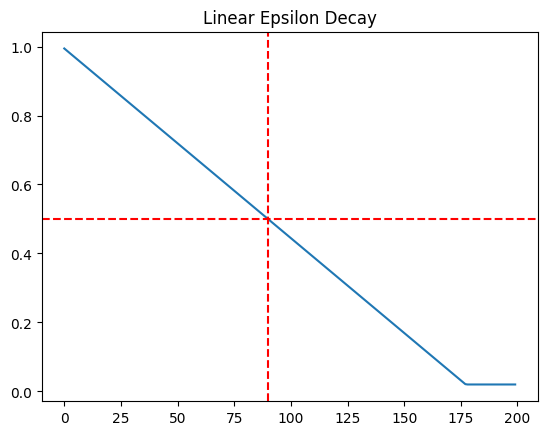

In [156]:
epsilon_arr = []
Epsilon = 1
EpsilonMin = 0.02
EpsilonDecay = 0.0055

for i in range(200):
    Epsilon = max(EpsilonMin, Epsilon - EpsilonDecay)
    epsilon_arr.append(Epsilon)

plt.plot(epsilon_arr)
plt.axhline(y=0.5, color='r', linestyle='--')
plt.axvline(next(x for x, epsilon in enumerate(epsilon_arr) if epsilon <= 0.5), color='r', linestyle='--')
plt.title('Linear Epsilon Decay')
plt.show()

#### Exponential Epsilon Decay:

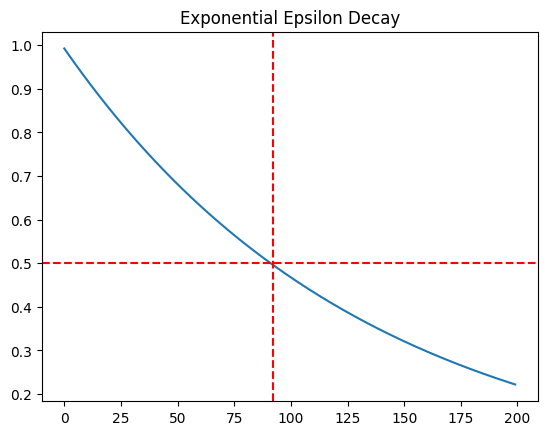

In [161]:
epsilon_arr = []
Epsilon = 1
EpsilonMin = 0.02
EpsilonDecay = 0.9925

for i in range(200):
    Epsilon = max(EpsilonMin, Epsilon * EpsilonDecay)
    epsilon_arr.append(Epsilon)

plt.plot(epsilon_arr)
plt.axhline(y=0.5, color='r', linestyle='--')
plt.axvline(next(x for x, epsilon in enumerate(epsilon_arr) if epsilon <= 0.5), color='r', linestyle='--')
plt.title('Exponential Epsilon Decay')
plt.show()

From the 2 graphs above, we can see that the epsilon value of 0.5 is reached at around 85 episodes before half the total episodes (100) for both methods. This is because we want the model to explore for the first half of the training and exploit for the second half, but have more time to exploit than explore. Note that here we are taking > 0.5 as exploration and < 0.5 as exploitation.

We will try both methods of epsilon decay and compare the results to see which we should use for our model.

#### Linear Epsilon Decay Rate 0.0055, Gamma 0.95

Model: "Main"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 40)             │         2,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,016 (27.41 KB)

 Trainable params: 7,016 (27.41 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Target"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 40)             │         2,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,016 (27.41 KB)

 Trainable params: 7,016 (27.41 KB)

 Non-trainable params: 0 (0.00 B)

Episode 0
DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory = 26
DID NOT TRAIN..., replay memory = 27


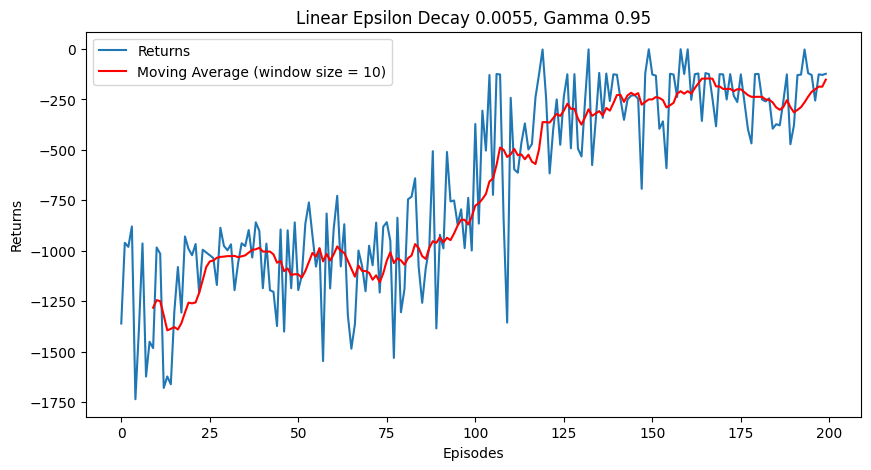

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [162]:
# Hyperparameters
IntermediateSize = 64
Epsilon = 1
NActions = 40
Gamma = 0.95
ReplayMemorySize = 10000
MinReplayMemory = 1000
UpdateTargetEveryThisEpisodes = 1
BatchSize = 32
EpsilonMin = 0.02
EpsilonDecay = 0.0055
LearningRate = 0.001
Momentum = 0.9

returns = []
frames = []
STARTTIME = time.time()

improvedDQN = DQN(
    IntermediateSize=IntermediateSize,
    InputShape=InputShape,
    NActions=NActions,
    Gamma=Gamma,
    ReplayMemorySize=ReplayMemorySize,
    MinReplayMemory=MinReplayMemory,
    UpdateTargetEveryThisEpisodes=UpdateTargetEveryThisEpisodes,
    BatchSize=BatchSize,
    LearningRate=LearningRate,
    Momentum=Momentum
)

for episode in range(200):
    print(f'Episode {episode}')
    OneEpisode(improvedDQN)
    Epsilon = max(EpsilonMin, Epsilon - EpsilonDecay)

print(f'Total time taken: {time.time() - STARTTIME} seconds ...')

ReturnPlot('improvedDQN', 'Linear Epsilon Decay 0.0055, Gamma 0.95')
SaveVideo('improvedDQN')

#### Exponential Epsilon Decay Rate 0.9925, Gamma 0.95

Model: "Main"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 40)             │         2,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,016 (27.41 KB)

 Trainable params: 7,016 (27.41 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Target"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 40)             │         2,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,016 (27.41 KB)

 Trainable params: 7,016 (27.41 KB)

 Non-trainable params: 0 (0.00 B)

Episode 0
DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory = 26
DID NOT TRAIN..., replay memory = 27


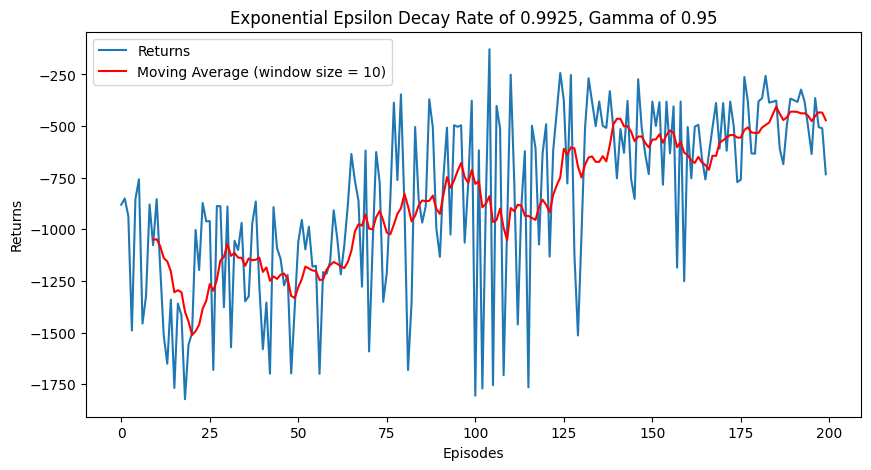

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [164]:
# Hyperparameters
IntermediateSize = 64
Epsilon = 1
NActions = 40
Gamma = 0.95
ReplayMemorySize = 10000
MinReplayMemory = 1000
UpdateTargetEveryThisEpisodes = 1
BatchSize = 32
EpsilonMin = 0.02
EpsilonDecay = 0.9925
LearningRate = 0.001
Momentum = 0.9

returns = []
frames = []
STARTTIME = time.time()

improved2DQN = DQN(
    IntermediateSize=IntermediateSize,
    InputShape=InputShape,
    NActions=NActions,
    Gamma=Gamma,
    ReplayMemorySize=ReplayMemorySize,
    MinReplayMemory=MinReplayMemory,
    UpdateTargetEveryThisEpisodes=UpdateTargetEveryThisEpisodes,
    BatchSize=BatchSize,
    LearningRate=LearningRate,
    Momentum=Momentum
)

for episode in range(200):
    print(f'Episode {episode}')
    OneEpisode(improved2DQN)
    Epsilon = max(EpsilonMin, Epsilon * EpsilonDecay)

print(f'Total time taken: {time.time() - STARTTIME} seconds ...')

ReturnPlot('improved2DQN', 'Exponential Epsilon Decay Rate 0.9925, Gamma 0.95')
SaveVideo('improved2DQN')

From the graphs shown above, we can see that the linear epsilon decay rate of 0.0055, gamma of 0.95 is more stable than the exponential epsilon decay Rate of 0.9925, gamma of 0.95. Hence, we will use the linear epsilon decay rate of 0.0055, gamma of 0.95 for our improved model.

### Learning Rate and Momentum

Learning rate is the step size of the agent. It determines how much the agent should learn from each batch of data.

A higher learning rate allows the agent to learn faster, but it may be unstable. A lower learning rate allows the agent to learn slower, but it may be more stable.

Momentum is the rate at which the agent should learn from the previous batch of data. It helps the agent to converge faster to the optimal solution.

A higher momentum (~0.99) will make the moving average more stable and smooth, relying more on the historical gradient information. This can help in reducing the noise and oscillations in the optimization path but may slow down the response to changes in the gradient direction.

A lower momentum (~0.8) will make the moving average more sensitive to recent changes in the gradient, making the optimizer more responsive to the latest gradient updates. This can be beneficial in scenarios where the gradients are rapidly changing, but it may also lead to higher variance and potentially more noise in the optimization process.

We can make use of learning rates and momentum to help stabilize the model and make it learn faster.

#### Learning Rate 0.0006

Model: "Main"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 40)             │         2,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,016 (27.41 KB)

 Trainable params: 7,016 (27.41 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Target"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 40)             │         2,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,016 (27.41 KB)

 Trainable params: 7,016 (27.41 KB)

 Non-trainable params: 0 (0.00 B)

Episode 0
DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory = 26
DID NOT TRAIN..., replay memory = 27


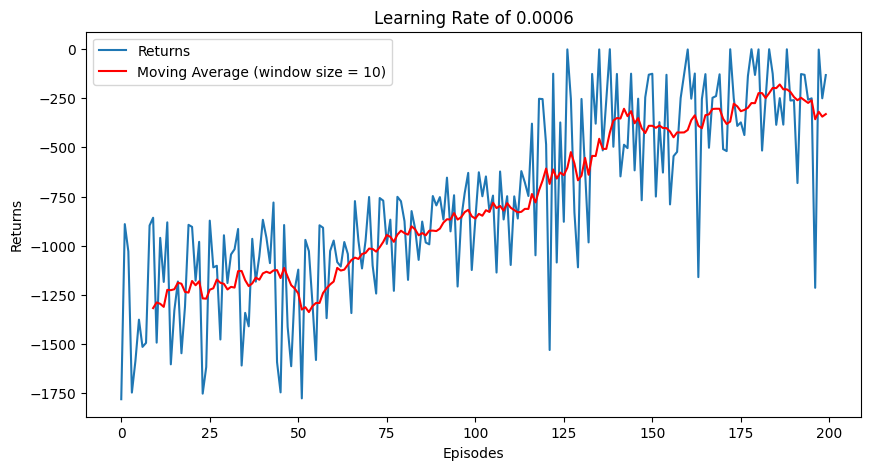

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [9]:
# Hyperparameters
IntermediateSize = 64
Epsilon = 1
NActions = 40
Gamma = 0.9
ReplayMemorySize = 10000
MinReplayMemory = 1000
UpdateTargetEveryThisEpisodes = 1
BatchSize = 32
EpsilonMin = 0.02
EpsilonDecay = 0.0055
LearningRate = 0.0006
Momentum = 0.9

returns = []
frames = []
STARTTIME = time.time()

improved4DQN = DQN(
    IntermediateSize=IntermediateSize,
    InputShape=InputShape,
    NActions=NActions,
    Gamma=Gamma,
    ReplayMemorySize=ReplayMemorySize,
    MinReplayMemory=MinReplayMemory,
    UpdateTargetEveryThisEpisodes=UpdateTargetEveryThisEpisodes,
    BatchSize=BatchSize,
    LearningRate=LearningRate,
    Momentum=Momentum 
)

for episode in range(200):
    print(f'Episode {episode}')
    OneEpisode(improved4DQN)
    Epsilon = max(EpsilonMin, Epsilon - EpsilonDecay)

print(f'Total time taken: {time.time() - STARTTIME} seconds ...')

ReturnPlot('improved4DQN', 'Learning Rate 0.0006')
SaveVideo('improved4DQN')

From the graph above, we can see that the model is more stable with a learning rate of 0.0006 and a momentum of 0.9. Hence, we will use a learning rate of 0.0006 and a momentum of 0.9 for our improved model.

### NActions & Intermediate Size

As our environment has a continuous action space, we can use the NActions parameter to discretize the action space into a fixed number of actions as DQN only works with discrete action spaces.

A higher NActions value will allow the agent to explore more actions, but it may also increase the computational complexity of the model. Hence, for a higher NActions value, we may need to increase the size of the intermediate layers to allow the model to learn more complex patterns.

A lower NActions value will allow the agent to explore fewer actions, but the difference in magnitudes between two adjacent actions may be huge which can affect the model's performance and stability. Hence, for a lower NActions value, we may need to decrease the size of the intermediate layers to allow the model to learn simpler patterns and not overfit.

#### NActions 60, Intermediate Size 256

Model: "Main"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 60)             │        15,420 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,236 (321.23 KB)

 Trainable params: 82,236 (321.23 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Target"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 60)             │        15,420 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,236 (321.23 KB)

 Trainable params: 82,236 (321.23 KB)

 Non-trainable params: 0 (0.00 B)

Episode 0
DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory = 26
DID NOT TRAIN..., replay memory = 27


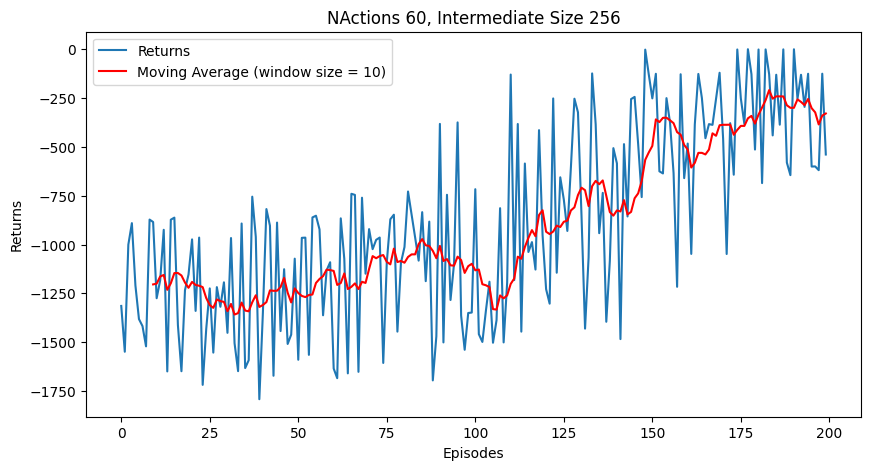

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [11]:
# Hyperparameters
IntermediateSize = 256
Epsilon = 1
NActions = 60
Gamma = 0.9
ReplayMemorySize = 10000
MinReplayMemory = 1000
UpdateTargetEveryThisEpisodes = 1
BatchSize = 32
EpsilonMin = 0.02
EpsilonDecay = 0.0055
LearningRate = 0.0006
Momentum = 0.9

returns = []
frames = []
STARTTIME = time.time()

improved5DQN = DQN(
    IntermediateSize=IntermediateSize,
    InputShape=InputShape,
    NActions=NActions,
    Gamma=Gamma,
    ReplayMemorySize=ReplayMemorySize,
    MinReplayMemory=MinReplayMemory,
    UpdateTargetEveryThisEpisodes=UpdateTargetEveryThisEpisodes,
    BatchSize=BatchSize,
    LearningRate=LearningRate,
    Momentum=Momentum 
)

for episode in range(200):
    print(f'Episode {episode}')
    OneEpisode(improved5DQN)
    Epsilon = max(EpsilonMin, Epsilon - EpsilonDecay)

print(f'Total time taken: {time.time() - STARTTIME} seconds ...')

ReturnPlot('improved5DQN', 'NActions 60, Intermediate Size 256')
SaveVideo('improved5DQN')

#### NActions 20, Intermediate Size 32

Model: "Main"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 20)             │           660 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,844 (7.20 KB)

 Trainable params: 1,844 (7.20 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Target"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 20)             │           660 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,844 (7.20 KB)

 Trainable params: 1,844 (7.20 KB)

 Non-trainable params: 0 (0.00 B)

Episode 0
DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory = 26
DID NOT TRAIN..., replay memory = 27


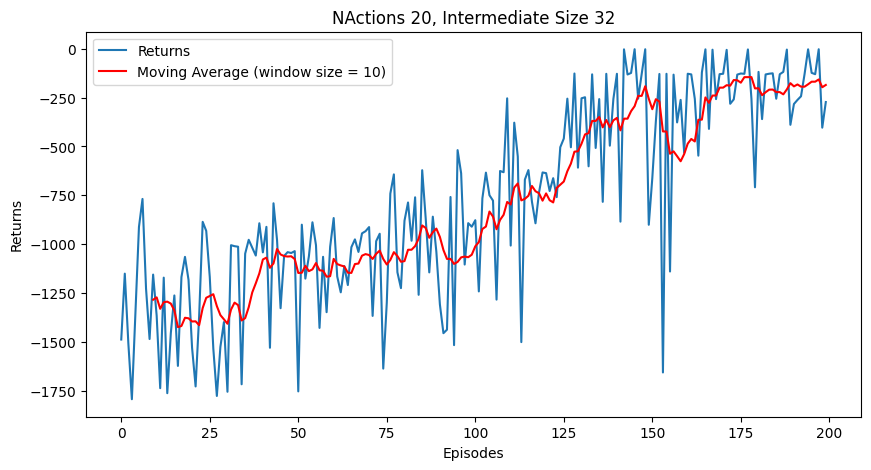

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [12]:
# Hyperparameters
IntermediateSize = 32
Epsilon = 1
NActions = 20
Gamma = 0.9
ReplayMemorySize = 10000
MinReplayMemory = 3000
UpdateTargetEveryThisEpisodes = 2
BatchSize = 32
EpsilonMin = 0.02
EpsilonDecay = 0.0055
LearningRate = 0.0006
Momentum = 0.9

returns = []
frames = []
STARTTIME = time.time()

improved6DQN = DQN(
    IntermediateSize=IntermediateSize,
    InputShape=InputShape,
    NActions=NActions,
    Gamma=Gamma,
    ReplayMemorySize=ReplayMemorySize,
    MinReplayMemory=MinReplayMemory,
    UpdateTargetEveryThisEpisodes=UpdateTargetEveryThisEpisodes,
    BatchSize=BatchSize,
    LearningRate=LearningRate,
    Momentum=Momentum
)

for episode in range(200):
    print(f'Episode {episode}')
    OneEpisode(improved6DQN)
    Epsilon = max(EpsilonMin, Epsilon - EpsilonDecay)

print(f'Total time taken: {time.time() - STARTTIME} seconds ...')

ReturnPlot('improved6DQN', 'NActions 20, Intermediate Size 32')
SaveVideo('improved6DQN')

From the graphs shown above, we can see that increasing the NActions and intermediate size affects the model stability as the returns fluctuate even more than before. Although decreasing the NActions and intermediate size does allow the model to perform decently well (stabalises at the end and hits 0 returns a few times), when we re-ran it a few more times, it produced inconsistent results. Hence, we will stick with NActions 40 and Intermediate Size 64 for our improved model.

### Minimum Replay Memory & Replay Memory Size

Having a higher minimum replay memory size will allow the agent to learn from more experiences before starting to train the model.

A higher replay memory size will allow the agent to remember more past experiences and learn from them.

#### Minimum Replay Memory 2000, Replay Memory Size 20000, Intermediate Size 128

Model: "Main"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,184 (86.66 KB)

 Trainable params: 22,184 (86.66 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Target"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,184 (86.66 KB)

 Trainable params: 22,184 (86.66 KB)

 Non-trainable params: 0 (0.00 B)

Episode 0
DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory = 26
DID NOT TRAIN..., replay memory = 27


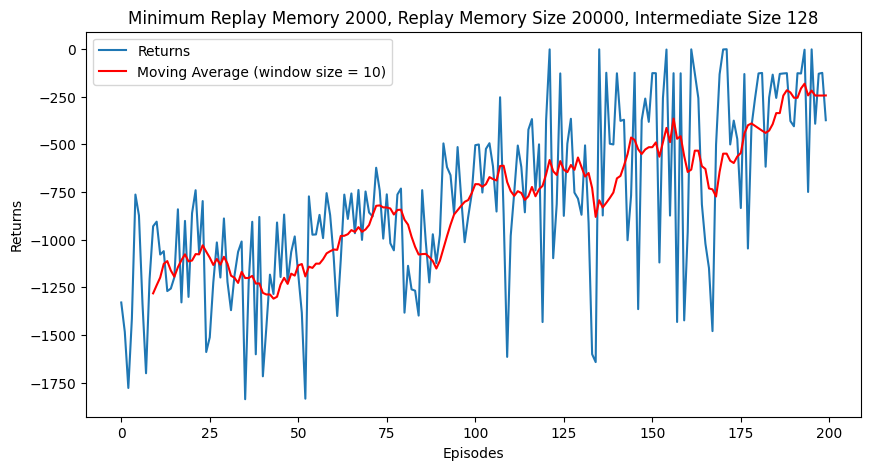

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [9]:
# Hyperparameters
IntermediateSize = 128
Epsilon = 1
NActions = 40
Gamma = 0.9
ReplayMemorySize = 20000
MinReplayMemory = 2000
UpdateTargetEveryThisEpisodes = 2
BatchSize = 32
EpsilonMin = 0.02
EpsilonDecay = 0.0055
LearningRate = 0.0006
Momentum = 0.9

returns = []
frames = []
STARTTIME = time.time()

improved7DQN = DQN(
    IntermediateSize=IntermediateSize,
    InputShape=InputShape,
    NActions=NActions,
    Gamma=Gamma,
    ReplayMemorySize=ReplayMemorySize,
    MinReplayMemory=MinReplayMemory,
    UpdateTargetEveryThisEpisodes=UpdateTargetEveryThisEpisodes,
    BatchSize=BatchSize,
    LearningRate=LearningRate,
    Momentum=Momentum
)

for episode in range(200):
    print(f'Episode {episode}')
    OneEpisode(improved7DQN)
    Epsilon = max(EpsilonMin, Epsilon - EpsilonDecay)

print(f'Total time taken: {time.time() - STARTTIME} seconds ...')

ReturnPlot('improved7DQN', 'Minimum Replay Memory 2000, Replay Memory Size 20000, Intermediate Size 128')
SaveVideo('improved7DQN')

From the graph shown above, we can see that increasing the minimum replay memory, replay memory size and intermediate size makes the model even more unstable. Hence, we will stick with minimum replay memory 1000, replay memory size 10000 and intermediate size 64.

### Batch Size & Target Update Frequency

A lower batch size allows the agent to update more frequently, which can lead to faster iterations and potentially quicker convergence. However, it can lead to noisy estimates of the gradient, which might cause the training process to be less stable and vary more, making the learning process more unpredictable. Smaller batches may not fully utilize the information contained in the replay buffer, potentially leading to less effective learning.

A large batch size on the other hand larger batches provide more stable and less noisy gradient estimates, which can improve the stability of training and potentially lead to achieving more consistent training results. It can also make better use of the replay buffer, allowing the model to learn from a more comprehensive set of experiences at each update.

A higher target update frequency allows the target network to be updated more frequently, which can allow learning algorithm to show improved performance on recent experiences due to quicker synchronization between the main and target networks. However, frequent updates can lead to instability because the target values used in the Q-value updates may change too rapidly, making the learning algorithm noisy and harder to converge.

A lower target update frequency allows less frequent updates which ensures that the target network provides more stable targets for the Q-value updates, helping in stabilizing training and improving convergence. However, if the target network is updated too infrequently, there might be a delay in the agent’s performance improvements, especially in environments with rapidly changing dynamics.

#### Batch Size 64, Target Update Frequency 2

Model: "Main"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 40)             │         2,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,016 (27.41 KB)

 Trainable params: 7,016 (27.41 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Target"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 40)             │         2,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,016 (27.41 KB)

 Trainable params: 7,016 (27.41 KB)

 Non-trainable params: 0 (0.00 B)

Episode 0
DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory = 26
DID NOT TRAIN..., replay memory = 27


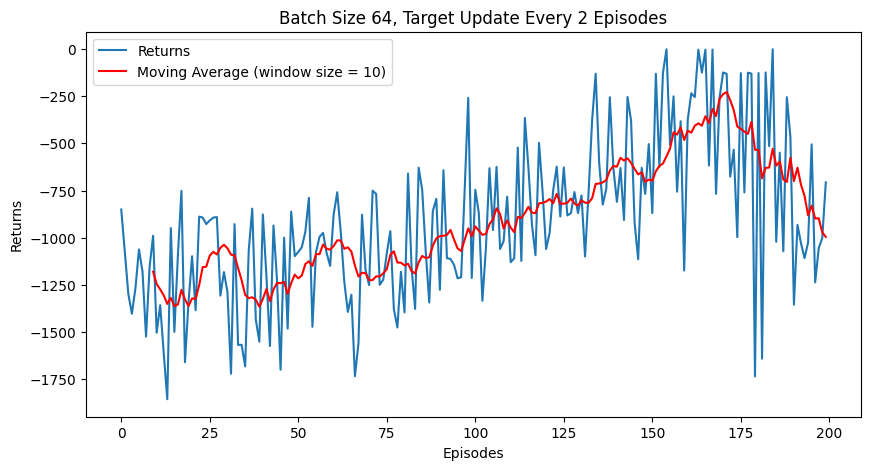

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [10]:
# Hyperparameters
IntermediateSize = 64
Epsilon = 1
NActions = 40
Gamma = 0.9
ReplayMemorySize = 10000
MinReplayMemory = 1000
UpdateTargetEveryThisEpisodes = 2
BatchSize = 64
EpsilonMin = 0.02
EpsilonDecay = 0.0055
LearningRate = 0.0006
Momentum = 0.9

returns = []
frames = []
STARTTIME = time.time()

improved8DQN = DQN(
    IntermediateSize=IntermediateSize,
    InputShape=InputShape,
    NActions=NActions,
    Gamma=Gamma,
    ReplayMemorySize=ReplayMemorySize,
    MinReplayMemory=MinReplayMemory,
    UpdateTargetEveryThisEpisodes=UpdateTargetEveryThisEpisodes,
    BatchSize=BatchSize,
    LearningRate=LearningRate,
    Momentum=Momentum
)

for episode in range(200):
    print(f'Episode {episode}')
    OneEpisode(improved8DQN)
    Epsilon = max(EpsilonMin, Epsilon - EpsilonDecay)

print(f'Total time taken: {time.time() - STARTTIME} seconds ...')

ReturnPlot('improved8DQN', 'Batch Size 64, Target Update Every 2 Episodes')
SaveVideo('improved8DQN')

Again., the graph shows instability in the model's performance and even a downward trend after around the 160th epsiode. Hence, we will stick with batch size 32 and target update frequency  of 1 for our improved model.

# 4. Model Testing

Model's key hyperparameters:
1. Gamma 0.95 - Ensures the agent is far-sighted and takes into consideration future rewards
2. Linear Epsilon Decay Rate 0.0055 - Ensures the agent explores more at the start and exploits more at the end
3. Minimum Epsilon 0.02 - Ensures that the agent does not explore too much at the end of the training with only a 2% chance of it taking a random action
4. Learning Rate 0.0006 - Ensures the agent learns faster and more stably
5. NActions 40 - Ensures the agent has enough variety of actions to choose from without overcomplicating the model (0.1Nm difference per discretised action)

With our hypertuned parameters, we will now test the model to see how well it performs for 10 episodes to test for stability.

## A. Save Weights For Every Episode

Model: "Main"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 40)             │         2,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,016 (27.41 KB)

 Trainable params: 7,016 (27.41 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Target"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 1stHiddenLayer (Dense)          │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ 2ndHiddenLayer (Dense)          │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 40)             │         2,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,016 (27.41 KB)

 Trainable params: 7,016 (27.41 KB)

 Non-trainable params: 0 (0.00 B)

Episode 0
DID NOT TRAIN..., replay memory = 1
DID NOT TRAIN..., replay memory = 2
DID NOT TRAIN..., replay memory = 3
DID NOT TRAIN..., replay memory = 4
DID NOT TRAIN..., replay memory = 5
DID NOT TRAIN..., replay memory = 6
DID NOT TRAIN..., replay memory = 7
DID NOT TRAIN..., replay memory = 8
DID NOT TRAIN..., replay memory = 9
DID NOT TRAIN..., replay memory = 10
DID NOT TRAIN..., replay memory = 11
DID NOT TRAIN..., replay memory = 12
DID NOT TRAIN..., replay memory = 13
DID NOT TRAIN..., replay memory = 14
DID NOT TRAIN..., replay memory = 15
DID NOT TRAIN..., replay memory = 16
DID NOT TRAIN..., replay memory = 17
DID NOT TRAIN..., replay memory = 18
DID NOT TRAIN..., replay memory = 19
DID NOT TRAIN..., replay memory = 20
DID NOT TRAIN..., replay memory = 21
DID NOT TRAIN..., replay memory = 22
DID NOT TRAIN..., replay memory = 23
DID NOT TRAIN..., replay memory = 24
DID NOT TRAIN..., replay memory = 25
DID NOT TRAIN..., replay memory = 26
DID NOT TRAIN..., replay memory = 27


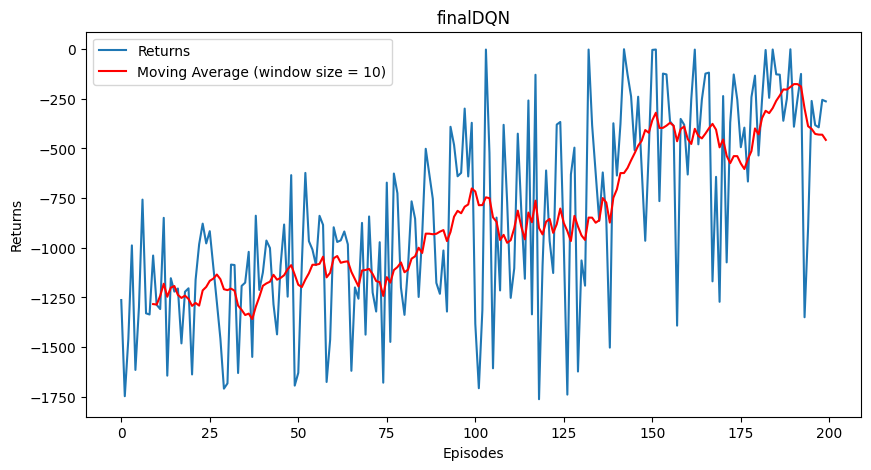

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [36]:
# Hyperparameters
IntermediateSize = 64
Epsilon = 1
NActions = 40
Gamma = 0.9
ReplayMemorySize = 10000
MinReplayMemory = 1000
UpdateTargetEveryThisEpisodes = 1
BatchSize = 32
EpsilonMin = 0.02
EpsilonDecay = 0.0055
LearningRate = 0.0006
Momentum = 0.9

returns = []
frames = []
STARTTIME = time.time()

finalDQN = DQN(
    IntermediateSize=IntermediateSize,
    InputShape=InputShape,
    NActions=NActions,
    Gamma=Gamma,
    ReplayMemorySize=ReplayMemorySize,
    MinReplayMemory=MinReplayMemory,
    UpdateTargetEveryThisEpisodes=UpdateTargetEveryThisEpisodes,
    BatchSize=BatchSize,
    LearningRate=LearningRate,
    Momentum=Momentum 
)

for episode in range(200):
    print(f'Episode {episode}')
    OneEpisode(finalDQN)
    finalDQN.SaveWeights(f'finalDQN_Episode_{episode}')
    Epsilon = max(EpsilonMin, Epsilon - EpsilonDecay)

print(f'Total time taken: {time.time() - STARTTIME} seconds ...') 

ReturnPlot('finalDQN', 'finalDQN')
SaveVideo('finalDQN')

## B. Load Weights

We will get episode with the highest return value and load the weights of that episode to see how well the model performs.

In [37]:
n = 3
np.argpartition(returns, -n)[-n:]

array([184, 189, 142], dtype=int64)

In [38]:
finalDQN.LoadWeights('finalDQN_Episode_189')

## C. Model Testing

Finished! Return: -131.90951710823938
Finished! Return: -1463.8462110238077
Finished! Return: -1682.8002220085727
Finished! Return: -135.1450959762014
Finished! Return: -5.9364533295211634
Finished! Return: -677.6239571426337
Finished! Return: -133.33733063568104
Finished! Return: -10.534598920321244
Finished! Return: -250.71363010529868
Finished! Return: -268.3548246058318
Average reward over 10 episodes: -476.0201840856109


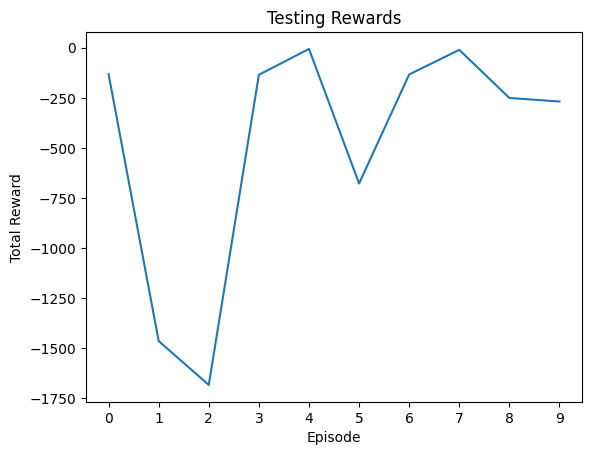

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [40]:
frames = []
testing_rewards = []
testing_episodes = 10

for episodes in range(testing_episodes):
    env = gym.make(f'{EnvName}')
    S = env.reset()
    ListOfRewards = []
    Done = False
    
    while not Done:
        Q = finalDQN.Main(S.reshape(-1, S.shape[0]))
        A = np.argmax(Q)
        A = PendulumActionConverter(A, NActions)
        AStep = np.array([A])
        A = PendulumInverseActionConverter(A, NActions)
        frame = env.render(mode='rgb_array')
        frames.append(frame)
        SNext, R, Done, Info = env.step(AStep)
        ListOfRewards.append(R)
        if Done:
            print(f'Finished! Return: {np.sum(ListOfRewards)}')
            testing_rewards.append(np.sum(ListOfRewards))
            env.close()
            break
        S = SNext

print(f'Average reward over {testing_episodes} episodes: {np.mean(testing_rewards)}')

plt.plot(testing_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Testing Rewards')
plt.xticks(list(range(testing_episodes)))
plt.show()

SaveVideo('finalDQN_testing')

## D. Conclusion and Model Performance Analysis

We can conclude that our model is unstable as the returns fluctuate a lot and do not stabilise at the end. This is due to DQN being unstable in nature and having to discretise a continuous action space. Although the model is quite unstable, it does hit a few high return values such as on episode 0, 3, 4 and 7. This means that it can perform 4/9 times which is around 44.44% of the time. However, the model is not consistent and hence, we will need to look into other algorithms such as PPO, A2C, DDPG, etc. to see if they can perform better than DQN in this environment.

**Explain the differences between this code and the lab code for cartpole.**

The cartpole action space is discretised by default, with only 2 discrete actions the agent can perform: push cart to the left and push cart to the right. However, for the pendulum environment, the action space is continuous, with the agent being able to apply a force between -2.0 and 2.0. The number of actions to discretise this range is a hyperparameter that can be tuned. The number of actions can be increased to allow the agent to make more precise decisions, but this comes at the cost of increased computational complexity. The number of actions can be decreased to reduce computational complexity, but this comes at the cost of reduced precision in the agent's decisions.

The lab code for cartpole uses an exponential epsilon decay method while we used a linear method to decay our epsilon value.

The lab code for cartpole also uses a replay memory size of 100000 which is 10 times more than what we used for the pendulum environment. This is because the cartpole environment has a larger state space (4 different observations) compared to the pendulum environment (3 different observations), so a larger replay memory size is needed to store more data.